# Chapter 13

http://allendowney.github.io/ThinkStats2/

## Reading

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [2]:
import numpy as np
import pandas as pd

import thinkstats2
import thinkplot

In [3]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

  Created wheel for empiricaldist: filename=empiricaldist-0.6.7-py3-none-any.whl size=11972 sha256=8483d96394fe2efd60daa1c7613adcf3b437f38782281f74a51fcf7423128053
  Stored in directory: /Users/lealia/Library/Caches/pip/wheels/1a/33/5a/05bbe93cd4709e7a777f8379efb54114a8f7f6dcb3787805fb
Successfully built empiricaldist


### Survival analysis

In [4]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [5]:
import nsfg

preg = nsfg.ReadFemPreg()
complete = preg.query("outcome in [1, 3, 4]").prglngth
cdf = thinkstats2.Cdf(complete, label="cdf")

Survival function is the complementary CDF:

In [6]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/survival.py")
import survival

Downloaded survival.py


In [7]:
def MakeSurvivalFromCdf(cdf, label=""):
    """
    Make a survival function based on a CDF.
    """
    ts = cdf.xs
    ss = 1 - cdf.ps
    return survival.SurvivalFunction(ts, ss, label)

In [8]:
sf = MakeSurvivalFromCdf(cdf, label='survival')

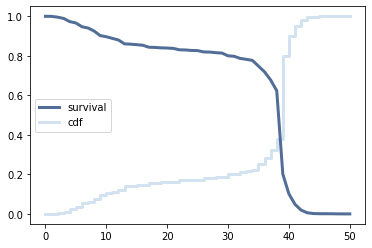

In [9]:
thinkplot.Plot(sf)
thinkplot.Cdf(cdf, alpha=0.2)
thinkplot.Config(loc='center left')

Hazard function:

In [10]:
hf = sf.MakeHazardFunction(label='hazard')

/Users/lealia/git/2022-summer-homeschool/thinkstats2/survival.py:71: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=self.ts)


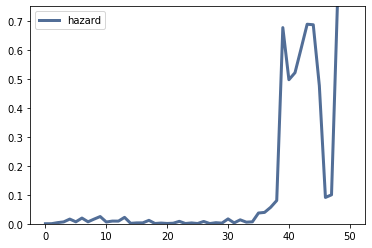

In [11]:
thinkplot.Plot(hf)
thinkplot.Config(ylim=[0, 0.75], loc="upper left")

In [12]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dat.gz"
)

In [13]:
resp6 = nsfg.ReadFemResp()

In [14]:
resp6.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp6["agemarry"] = (resp6.cmmarrhx - resp6.cmbirth) / 12.0
resp6["age"] = (resp6.cmintvw - resp6.cmbirth) / 12.0

In [15]:
# age at first marriage for people who are married
complete = resp6[resp6.evrmarry == 1].agemarry.dropna()
# age at interview for people who are not married
ongoing = resp6[resp6.evrmarry == 0].age

Estimate hazard function using Kaplan-Meier method

In [16]:
from collections import Counter

def EstimateHazardFunction(complete, ongoing, label="", verbose=False):
    """
    Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    label: string
    verbose: whether to display intermediate results
    """
    if np.sum(np.isnan(complete)):
        raise ValueError("`complete` contains NaNs.")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("`ongoing` contains NaNs.")
    
    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)
    
    # Create sorted list of all ages
    ts = list(hist_complete | hist_ongoing)
    ts.sort()
    
    at_risk = len(complete) + len(ongoing)
    
    lams = pd.Series(index=ts, dtype=float)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]
        
        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored
        
    return survival.HazardFunction(lams, label=label)

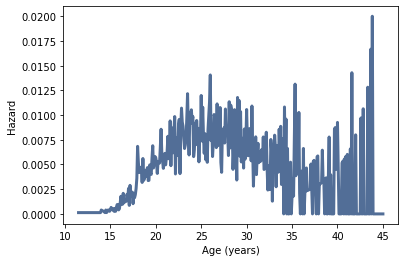

In [17]:
hf = EstimateHazardFunction(complete, ongoing)
thinkplot.Plot(hf)
thinkplot.Config(xlabel="Age (years)", ylabel="Hazard")

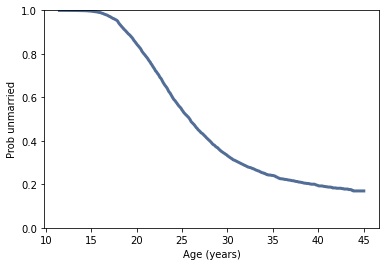

In [18]:
sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel="Age (years)", ylabel="Prob unmarried", ylim=[0, 1])

### Quantifying uncertainty

In [20]:
def EstimateMarriageSurvival(resp):
    """
    Estimates the survival curve.
    
    returns: pair of HazardFunction, SurvivalFunction
    """
    # Note: filling missing values would be better than dropping them
    complete = resp[resp.evrmarry == 1].agemarry.dropna()
    ongoing = resp[resp.evrmarry == 0].age
    
    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()
    
    return hf, sf

In [21]:
def ResampleSurvival(resp, iters=101):
    """
    Resamples respondents and estimates the survival function.
    """
    _, sf = EstimateMarriageSurvival(resp)
    thinkplot.Plot(sf)
    
    low, high = resp.agemarry.min(), resp.agemarry.max()
    ts = np.arange(low, high, 1 / 12)
    
    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(resp)
        _, sf = EstimateMarriageSurvival(sample)
        ss_seq.append(sf.Probs(ts))
        
    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color='gray', label='90% CI')

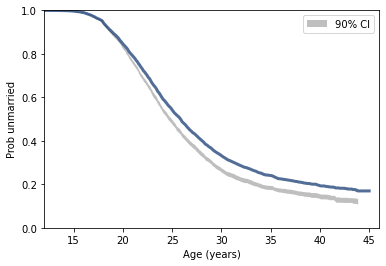

In [22]:
ResampleSurvival(resp6)
thinkplot.Config(
    xlabel="Age (years)",
    ylabel="Prob unmarried",
    xlim=[12, 46],
    ylim=[0, 1],
    loc="upper right",
)

### Cohort effects

In [23]:
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/1995FemRespData.dat.gz"
)
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct"
)
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz"
)
resp5 = survival.ReadFemResp1995()
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()
resps = [resp5, resp6, resp7]

Downloaded 1995FemRespData.dat.gz
Downloaded 2006_2010_FemRespSetup.dct
Downloaded 2006_2010_FemResp.dat.gz


In [24]:
def AddLabelsByDecade(groups, **options):
    """
    Draws fake points in order to add labels to the legend.
    """
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        label = "%d0s" % name
        thinkplot.Plot([15], [1], label=label, **options)

In [25]:
def EstimateMarriageSurvivalByDecade(groups, **options):
    """
    Groups respondents by decade and plots survival curves.
    """
    thinkplot.PrePlot(len(groups))
    for _, group in groups:
        _, sf = EstimateMarriageSurvival(group)
        thinkplot.Plot(sf, **options)

In [26]:
def PlotResampledByDecade(resps, iters=11, predict_flag=False, omit=None):
    """Plots survival curves for resampled data.

    resps: list of DataFrames
    iters: number of resamples to plot
    predict_flag: whether to also plot predictions
    """
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")

        if omit:
            groups = [(name, group) for name, group in groups if name not in omit]

        # TODO: refactor this to collect resampled estimates and
        # plot shaded areas
        if i == 0:
            AddLabelsByDecade(groups, alpha=0.7)

        if predict_flag:
            PlotPredictionsByDecade(groups, alpha=0.1)
            EstimateMarriageSurvivalByDecade(groups, alpha=0.1)
        else:
            EstimateMarriageSurvivalByDecade(groups, alpha=0.2)

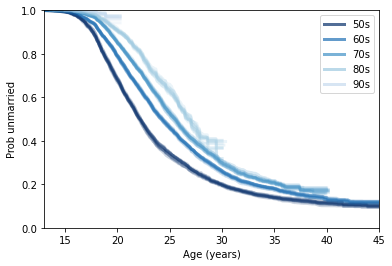

In [27]:
PlotResampledByDecade(resps)
thinkplot.Config(
    xlabel="Age (years)", ylabel="Prob unmarried", xlim=[13, 45], ylim=[0, 1]
)

We can generate predictions by assuming that the hazard function of each generation will be the same as for the previous generation.

In [35]:
def PlotPredictionsByDecade(groups, **options):
    hfs = []
    for _, group in groups:
        hf, sf = EstimateMarriageSurvival(group)
        hfs.append(hf)
        
    thinkplot.PrePlot(len(hfs))
    
    for i, hf in enumerate(hfs):
        if i > 0:
            hf.Extend(hfs[i - 1])
        sf = hf.MakeSurvival()
        thinkplot.Plot(sf, **options)

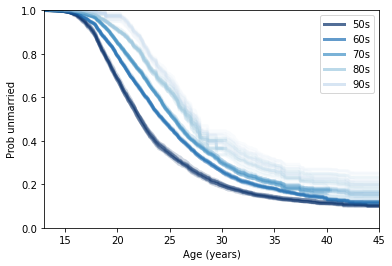

In [36]:
PlotResampledByDecade(resps, predict_flag=True)
thinkplot.Config(
    xlabel="Age (years)", ylabel="Prob unmarried", xlim=[13, 45], ylim=[0, 1]
)

### Remaining lifetime

In [37]:
preg = nsfg.ReadFemPreg()

complete = preg.query("outcome in [1, 3, 4]").prglngth
print("Number of complete pregnancies", len(complete))
ongoing = preg[preg.outcome == 6].prglngth
print("Number of ongoing pregnancies", len(ongoing))

hf = EstimateHazardFunction(complete, ongoing)
sf1 = hf.MakeSurvival()

Number of complete pregnancies 11189
Number of ongoing pregnancies 352


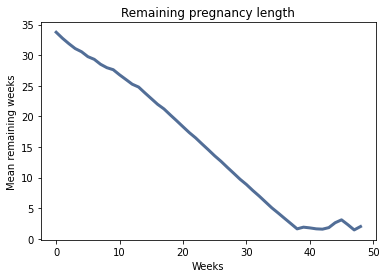

In [38]:
rem_life1 = sf1.RemainingLifetime()
thinkplot.Plot(rem_life1)
thinkplot.Config(
    title="Remaining pregnancy length", xlabel="Weeks", ylabel="Mean remaining weeks"
)

After week 36, the process becomes *memoryless*.

In [39]:
hf, sf2 = EstimateMarriageSurvival(resp6)

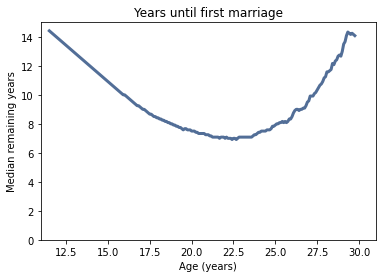

In [40]:
func = lambda pmf: pmf.Percentile(50)
rem_life2 = sf2.RemainingLifetime(filler=np.inf, func=func)

thinkplot.Plot(rem_life2)
thinkplot.Config(
    title="Years until first marriage",
    ylim=[0, 15],
    xlim=[11, 31],
    xlabel="Age (years)",
    ylabel="Median remaining years",
)

## Exercises

**Exercise:**    In NSFG Cycles 6 and 7, the variable `cmdivorcx` contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [41]:
def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp["notdivorced"] = resp.cmdivorcx.isnull().astype(int)
    resp["duration"] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp["durationsofar"] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime("1899-12-15")
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [42]:
CleanData(resp6)
CleanData(resp7)

married6 = resp6[resp6.evrmarry == 1]
married7 = resp7[resp7.evrmarry == 1]

In [43]:
married6.head()

,caseid,cmbirth,evrmarry,cmmarrhx,cmdivorcx,parity,finalwgt,cmintvw,agemarry,age,year,decade,fives,notdivorced,duration,durationsofar
1,5012,718,True,974.0,1077.0,1,4744.191350,1233,21.333333,42.916667,59,5,11,0,8.583333,21.583333
2,11586,708,True,910.0,938.0,1,4744.191350,1234,16.833333,43.833333,58,5,11,0,2.333333,27.000000
5,845,727,True,937.0,NaN,6,4705.681352,1234,17.500000,42.250000,60,6,12,1,NaN,24.750000
8,8656,780,True,1003.0,NaN,3,6520.021223,1237,18.583333,38.083333,64,6,12,1,NaN,19.500000
10,5917,714,True,953.0,NaN,2,3488.586646,1233,19.916667,43.250000,59,5,11,1,NaN,23.333333


In [49]:
complete6 = married6[married6.notdivorced == 0].duration.dropna()
ongoing6 = married6[married6.notdivorced == 1].durationsofar.dropna()

complete7 = married7[married7.notdivorced == 0].duration.dropna()
ongoing7 = married7[married7.notdivorced == 1].durationsofar.dropna()

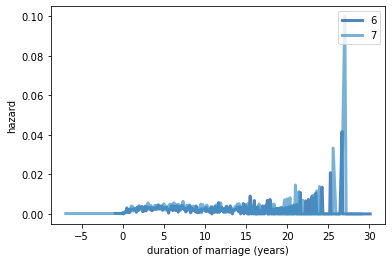

In [50]:
hf6 = EstimateHazardFunction(complete6, ongoing6)
sf6 = hf6.MakeSurvival()
hf7 = EstimateHazardFunction(complete7, ongoing7)
sf7 = hf7.MakeSurvival()

thinkplot.PrePlot(2)
thinkplot.Plot(hf6, label='6')
thinkplot.Plot(hf7, label='7')
thinkplot.Config(xlabel='duration of marriage (years)', ylabel='hazard')

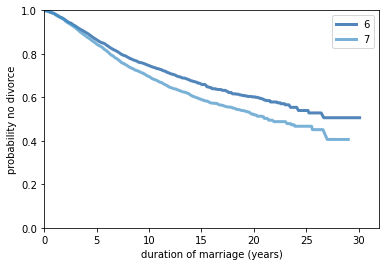

In [66]:
thinkplot.PrePlot(2)
thinkplot.Plot(sf6, label='6')
thinkplot.Plot(sf7, label='7')
thinkplot.Config(
    xlabel='duration of marriage (years)', 
    ylabel='probability no divorce',
    xlim=[0, None],
    ylim=[0, 1],
)

In [55]:
def EstimateDivorceSurvival(married):
    complete = married[married.notdivorced == 0].duration.dropna()
    ongoing = married[married.notdivorced == 1].durationsofar.dropna()

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()
    
    return hf, sf

In [63]:
def ResampleSurvival(married, iters=101):
    """Resamples respondents and estimates the survival function.

    resp: DataFrame of respondents
    iters: number of resamples
    """
    _, sf = EstimateDivorceSurvival(married)
    thinkplot.Plot(sf)

    low, high = married.duration.min(), married.durationsofar.max()
    ts = np.arange(low, high, 1 / 12.0)

    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(married)
        _, sf = EstimateDivorceSurvival(sample)
        ss_seq.append(sf.Probs(ts))

    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color="gray", label="90% CI")
    
    thinkplot.Config(
        xlabel='duration of marriage (years)',
        ylabel='probability no divorce',
        xlim=[0, None]
    )

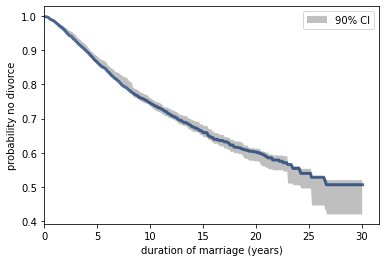

In [64]:
ResampleSurvival(married6)

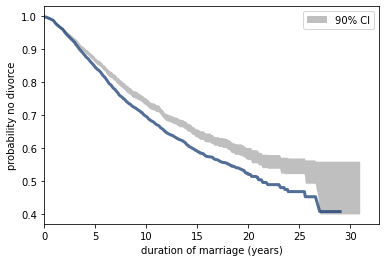

In [65]:
ResampleSurvival(married7)

In [69]:
def EstimateDivorceSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for _, group in groups:
        _, sf = EstimateDivorceSurvival(group)
        thinkplot.Plot(sf, **options)


def PlotResampledByDecade(marrieds, iters=11, predict_flag=False, omit=None):
    """Plots survival curves for resampled data.

    resps: list of DataFrames
    iters: number of resamples to plot
    predict_flag: whether to also plot predictions
    """
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(married) for married in marrieds]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")

        if omit:
            groups = [(name, group) for name, group in groups if name not in omit]

        # TODO: refactor this to collect resampled estimates and
        # plot shaded areas
        if i == 0:
            AddLabelsByDecade(groups, alpha=0.7)

        if predict_flag:
            PlotPredictionsByDecade(groups, alpha=0.1)
            EstimateDivorceSurvivalByDecade(groups, alpha=0.1)
        else:
            EstimateDivorceSurvivalByDecade(groups, alpha=0.2)

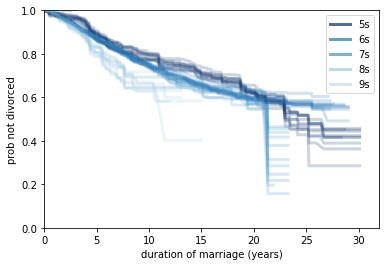

In [79]:
marrieds = [married6, married7]

PlotResampledByDecade(marrieds)
thinkplot.Config(
    xlabel='duration of marriage (years)', ylabel='prob not divorced',
    xlim=[0, None], ylim=[0, 1]
)

In [73]:
# Group by age at first marriage
for married in marrieds:
    married['agegroupmarry'] = np.floor(married.agemarry / 10) * 10

/var/folders/pv/jsnn4l_x60x5zx013kbk8l280000gn/T/ipykernel_14687/2555374983.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  married['agegroupmarry'] = np.floor(married.agemarry / 10) * 10
/var/folders/pv/jsnn4l_x60x5zx013kbk8l280000gn/T/ipykernel_14687/2555374983.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  married['agegroupmarry'] = np.floor(married.agemarry / 10) * 10


In [77]:
def AddLabelsByDecade(groups, **options):
    """
    Draws fake points in order to add labels to the legend.
    """
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        label = "%ds" % name
        thinkplot.Plot([15], [1], label=label, **options)
        
def PlotResampledByAgeDecade(marrieds, iters=11, predict_flag=False, omit=None):
    """Plots survival curves for resampled data.

    resps: list of DataFrames
    iters: number of resamples to plot
    predict_flag: whether to also plot predictions
    """
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(married) for married in marrieds]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("agegroupmarry")

        if omit:
            groups = [(name, group) for name, group in groups if name not in omit]

        # TODO: refactor this to collect resampled estimates and
        # plot shaded areas
        if i == 0:
            AddLabelsByDecade(groups, alpha=0.7)

        if predict_flag:
            PlotPredictionsByDecade(groups, alpha=0.1)
            EstimateDivorceSurvivalByDecade(groups, alpha=0.1)
        else:
            EstimateDivorceSurvivalByDecade(groups, alpha=0.2)

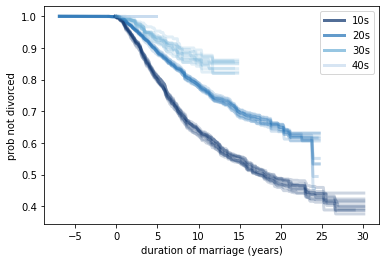

In [78]:
PlotResampledByAgeDecade(marrieds)
thinkplot.Config(
    xlabel='duration of marriage (years)', ylabel='prob not divorced'
)